# **Lezione 8**

### **Introduzione**

In meccanica quantistica, il principio variazionale afferma che il valor medio dell'hamiltoniana su qualsiasi funzione d'onda di prova normalizzata ha come limite inferiore, il valore dell'energia dello stato fondamentale $E_0$:
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

Questo metodo è la base dei cosidetti metodi Monte Carlo Variazionali (VMC), dove si combinano una funzione d'onda di prova parametrizzata con tecniche stocastiche per stimare gli integrali e ottimizzare i parametri variazionali.

In questa esperienza consideriamo una particella quantistica che si muove in uno spazio unidimensionale, soggetta al potenziale:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$
Questo modello quantistico 1D non è risolvibile analiticamente e va dunque affrontato con metodi numerici. Per ottenere una funzione d'onda approssimata per lo stato fondamentale, utilizziamo come funzione d'onda di prova:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
e^{-\frac{(x+\mu)^2}{2\sigma^2}} \hspace{1cm} \text{due parametri variazionali: } \sigma \text{ e } \mu
$$

### **Esercizio 8.1**

Lo scopo dell'esercizio è scrivere un codice che, sfruttando l'algoritmo di Metropolis, campioni $|\Psi_T(x)|^2$ e calcoli il valor medio dell'hamiltoniana (con data blocking):
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} = \int P(x) \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

L’obiettivo finale consiste nell’ottimizzazione dei parametri variazionali $\mu$ e $\sigma$ al fine di minimizzare l’energia aspettata $\langle \hat{H} \rangle_T$, ottenendo così una stima quanto più precisa possibile dello stato fondamentale del sistema.

##### **Implementazione numerica e codice**

Come richiesto dalla consegna, per stimare il valor medio dell'hamiltoniana, utiliziamo l'apporoccio Monte Carlo con l'algoritmo di Metropolis per campionare la distribuzione di probabilità $P(x)$ definita sopra. 

Le proposte di nuova posizione vengono accettate o rifiutate in base al rapporto:
$$
A(x\rightarrow y) = \min \Bigg( 1, \frac{|\Psi_T(y)|^2}{|\Psi_T(x)|^2} \Bigg)
$$
e sono generate da una distribuzione uniforme centrata sull'attuale posizione, controllata da un parametro di passo delta. 
Con una chiara ispirazione al  $M(RT)^2$ presente in system.cpp di NSL_SIMULATOR, all'interno del mio codice l'algoritmo è stato realizzato in questo modo:
```cpp
    bool metro(double x , double y, double mu, double sigma, Random&  rnd){ // Metropolis algorithm
      bool decision = false;
      double psi_x = psi(x , mu , sigma);
      double psi_y = psi(y , mu , sigma);
      double acceptance = min( 1. , pow(psi_y/psi_x ,2) );
      if(rnd.Rannyu() < acceptance ) decision = true; 
      return decision;    
    }
``` 
<br>

Detto questo, vediamo ora come ho implementato il campionamento del valor medio dell'energia, ossia guardiamo il **main**.   
<br>
<div style="width: 48%; float: left;">

Come prima cosa, i parametri di simulazione sono passati dal file di input `sim_parameters.dat`, a fianco mostrato.  
Di nuovo fortemente ispirato dal NSL_SIMULATOR, mi ha permesso di modificare agilmente i parametri $\mu$ e $\sigma$, senza dover mettere mano direttamente al codice.
</div>
<div style="width: 48%; float: right;">

>NSTEPS $\hspace{0.47cm} $ 10000   
>NBLOCK $\hspace{0.39cm} $  100   
>MU   $\hspace{1.01cm} $    1  
>SIGMA  $\hspace{0.6cm} $ 1  
>DELTA  $\hspace{0.69cm} $ 2.08 
</div>
<div style="clear: both;"></div>


<br>
<div style="width: 48%; float: left;">

Successivamente, dopo aver definito tutte le varie variabili di appoggio che serviranno nei calcoli, si passa al loop sui blocchi e passi, dove avviene il calcolo dell'energia. Ad ogni passo:

* Viene proposto un nuovo valore y spostando x di un valore casuale in [-delta, delta].

* La proposta viene accettata o rifiutata tramite la funzione metro(...), che implementa il Metropolis.

* Se accettato, x viene aggiornato, e la nuova posizione viene scritta in psi_sampled.dat.

* L’energia 'istantanea' $H\psi(x)$ viene calcolata e accumulata.

</div>
<div style="width: 48%; float: right;">

```cpp
for (int i = 0; i < n_blocks; i++) {
  ...
  for (int j = 0; j < n_steps; j++) {
    double y = x + rnd.Rannyu(-1.0,1.0) * delta;
    if (metro(x, y, mu, sigma, rnd)) {
      x = y;
      n_accepted++;
      psi_file << x << endl;
    }
    stima += Hpsi(x, mu, sigma);
  }
}
```
</div>
<div style="clear: both;"></div>

Successivamente si procede con il solito data-blocking. Calcolata la media del blocco, le medie cumulative vengono aggiornate per ottenere media progressiva e incertezza statistica tramite <font color="#FFF4B1">error_double</font>(). Tutti i risultati, compresa l'accettanza sono stampati su diversi file, pronti per il post processing.

##### **Risultati**

Seguono ora due grafici, prodotti dai dati ottenuti con il campionamento Metropolis della funzione d’onda variazionale ($\mu=0$ e $\sigma=1$). Il primo confronta la distribuzione dei campioni con la funzione $|\psi_T(x)|^2$ teorica, mentre il secondo mostra l’evoluzione dell’energia media per blocco, con relativa incertezza statistica.


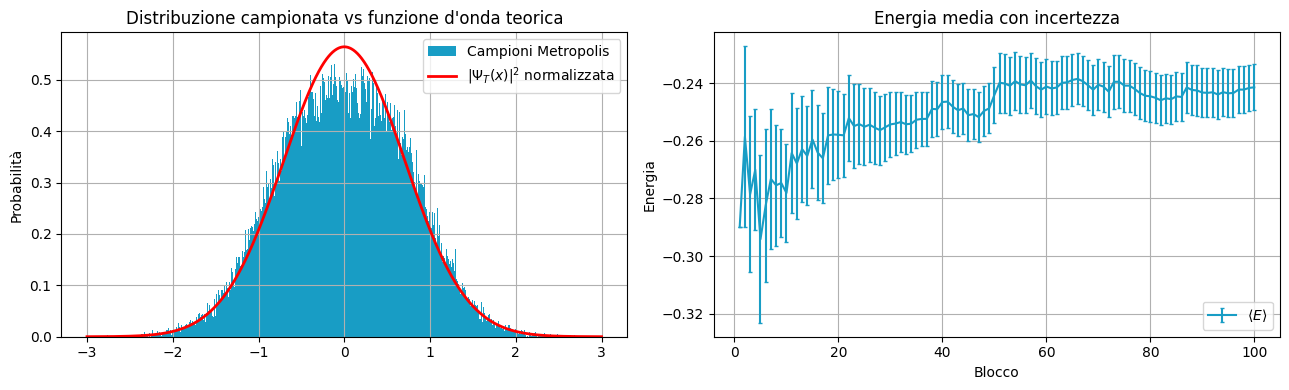

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Funzione d'onda non normalizzata
def psi2_unnormalized(x, mu, sigma):
    return (np.exp(-(x - mu)**2 / (2 * sigma**2)) + np.exp(-(x + mu)**2 / (2 * sigma**2)))**2

# Funzione d'onda normalizzata
def psi2_normalized(x, mu, sigma):
    norm, _ = quad(psi2_unnormalized, -10*sigma, 10*sigma, args=(mu, sigma))
    return psi2_unnormalized(x, mu, sigma) / norm


x = np.loadtxt("Files_8.1/psi_sampled.dat")
block, e_ave, e_err = np.loadtxt("Files_8.1/energy.dat", usecols=(0,2,3), unpack=True)

fig, ax = plt.subplots(1, 2, figsize=(13, 4), sharex=False)

ax[0].hist(x, bins=500, density=True, label='Campioni Metropolis', color="#189DC5")
x_fit = np.linspace(-3, 3, 1000)
ax[0].plot(x_fit, psi2_normalized(x_fit, 0, 1), color='r', linewidth=2, label=r'$|\Psi_T(x)|^2$ normalizzata')
ax[0].set_ylabel("Probabilità")
ax[0].set_title("Distribuzione campionata vs funzione d'onda teorica")
ax[0].legend()
ax[0].grid(True)

ax[1].errorbar(block, e_ave, yerr=e_err, label=r'$\langle E \rangle$', capsize=1.5, color="#189DC5")
ax[1].set_xlabel("Blocco")
ax[1].set_ylabel("Energia")
ax[1].set_title("Energia media con incertezza")
ax[1].grid(True)
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


<div style="width: 48%; float: left;">

A sinistra troviamo un grafico che confronta l'istogramma dei valori generati con l'algoritmo di metropolis con la densità di probabilità teorica $|\psi_T(x;\mu,\sigma)|^2$, con:
$$
\mu =0 \hspace{1cm} \sigma=1
$$

La distribuzione campionata e la curva teorica si trovano in un buon accordo, suggerendo dunque una buona implementazione del codice. 

</div>
<div style="width: 48%; float: right;">

A destra è presente il grafico di $\langle E \rangle$, calcolato con il data blocking, in funzione dei blocchi. Si notano la solita fase iniziale con maggiore fluttuazione, seguita da una stabilizzazione dell’energia intorno a un valore medio costante

L’energia finale rappresenta una buona stima dell’energia attesa della funzione d’onda variazionale con i parametri utilizzati, ed è il valore che si andrà a minimizzare per ottimizzare $\mu$ e $\sigma$.

</div>
<div style="clear: both;"></div>

### **Esercizio 8.2**

In questo secondo esercizio affrontiamo la parte variazionale del problema. Si dovranno ottimizzare i paramentri $\mu$ e $\sigma$ della funzione d'onda di test $\psi_T(x; \mu, \sigma)$, con lo scopo di minimizzare il valore medio dell'energia $\langle \hat{H}\rangle$. Per realizzare ciò si dovrà combinare il codice Monte Carlo dell'esercizio precedente con un algoritmo di Simulated Annealing (SA).

Da [geeksforgeeks](https://www.geeksforgeeks.org/what-is-simulated-annealing/#what-is-simulated-annealing): il Simulated Annealing è un algoritmo di ottimizzazione usato per cercare la soluzione migliore, in un ampio spazio di soluzioni. Il nome e il concetto derivano dal processo di ricottura in metallurgia, in cui un materiale viene riscaldato e poi raffreddato lentamente per rimuovere i difetti e ottenere una struttura cristallina stabile. Nell'algoritmo, il "calore" è gestito da una temperatura fittizia e corrisponde al grado di casualità nel processo di ricerca, che diminuisce nel tempo (cooling schedule) per migliorare la soluzione.

##### **Il main**
Vediamo com'è stato realizzato il SA per trovare i valori ottimali di $\mu$ e $\sigma$ che minimizzano l'energia.

**Inizio del ciclo di SA**  
Si parte da una temperatura iniziale $T=2.0$ e si riduce ad ogni ciclo moltiplicandola per $0.99$, fino a raggiungere una temperatura finale $T\approx 0.01$. Questo metodo di raffreddamento permette di rallentare sempre di più l'esplorazione dello spazio dei parametri più la temperatura si abbassa.

**Ciclo interno per ogni temperatura**  
Per ogni valore di temperatura vengono effettuate 100 proposte di parametri diversi:

* Si propone un nuovo valore di $\mu$, spostandolo in modo casuale intorno al valore precedente, con un'ampiezza controllata dalla temperatura, così che più il sistema si raffredda, più questo effettua una ricerca fine vicino al minimo individuato.

* Si propone un nuovo sigma in maniera simile, ma si impone un vincolo inferiore per evitare che diventi troppo piccolo (funzione d’onda troppo stretta e instabile numericamente).

Viene poi calcolata l'energia con i nuovi parametri grazie alla chiamata della funzione <font color="#FFF4C2">H_measurement</font>(). Questa funzione calcola il valore medio dell’energia $\langle \hat{H} \rangle_T$ data la coppia $\mu$ e $\sigma$ in maniera simile all'esercizio precedente. 

All'interno di questa viene chiamata un'altra funzione: <font color="#FFF4C2">find_delta</font>() che ottimizza il valore di $delta$ e svolge un importante ruolo nel rendere l'algoritmo efficiente: 
* Parte da $x_0$ e fa un certo numero di passi, tenendo traccia di quanti vengono accettati.
* Confronta la frazione di accettazione ottenuta con quella desiderata del 50%.
* Se è troppo alta, aumenta delta (accetto troppo = passi piccoli).
* Se è troppo bassa, riduce delta (rifiuto troppo = passi grandi)

Continuando nel del ciclo for interno, calcolata la nuova energia, questa viene confrontata con quella precedente e si decide se accettare la modifica dei parametri con la regola di accettazione Metropolis, con probabilità:
$$
P = \min \Big(1, e^{-\beta (E_{new}-E)}\Big) \hspace{1cm} \text{con } \beta = \frac{1}{T} 
$$
Se la proposta è accettata si aggiornano $\mu, \sigma$ e H (con errore), che vengono stampati sul file `evo_parameters.dat`, insieme alla temperatura attuale.

Una volta conclusa l’ottimizzazione, si richiama il codice dell’esercizio 8.1 con i parametri ottimizzati per produrre i grafici richiesti (energia con incertezza, distribuzione campionata).

##### **Risultati**

Di seguito mostro il grafico della funzione d'onda e il valore progressivo dell'energia con i parametri ricavati dal Simulated Annealing, confrontati con la soluzione matriciale del sistema, descritta nella sezione supplementare della consegna e calcolata nello script Python.

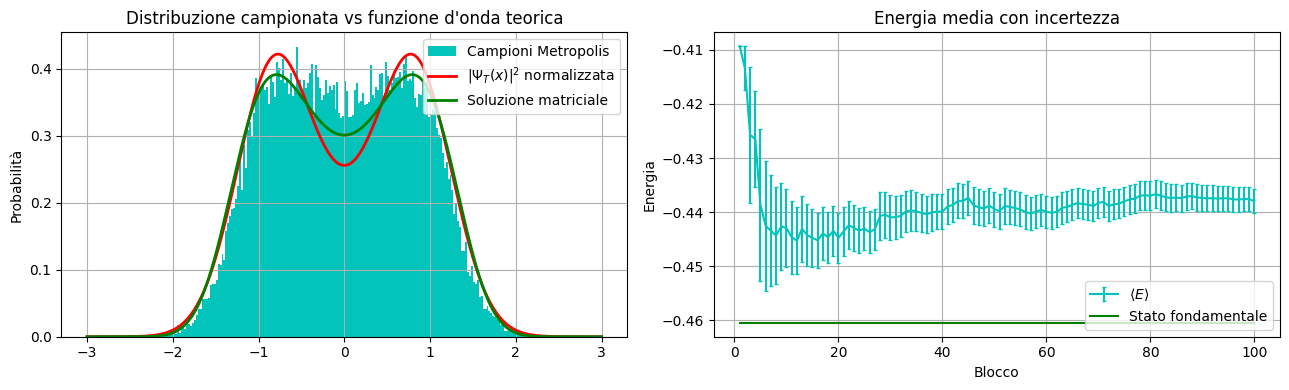

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np

# Matrix solution, see supplementary material for details
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
N = 1000 # number of iterations

# Step sizes
x_fit = np.linspace(-3, 3, 1000)
dx = x_fit[1] - x_fit[0] # the step size
V = Vpot(x_fit)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

# ============================================================================================

# Funzione d'onda non normalizzata
def psi2_unnormalized(x, mu, sigma):
    return (np.exp(-(x - mu)**2 / (2 * sigma**2)) + np.exp(-(x + mu)**2 / (2 * sigma**2)))**2

# Funzione d'onda normalizzata
def psi2_normalized(x, mu, sigma):
    norm, _ = quad(psi2_unnormalized, -10*sigma, 10*sigma, args=(mu, sigma))
    return psi2_unnormalized(x, mu, sigma) / norm

x = np.loadtxt("Files_8.2/psi_sampled.dat")
block, e_ave, e_err = np.loadtxt("Files_8.2/energy.dat", usecols=(0,2,3), unpack=True)
T, mu, sigma, en, err_en = np.loadtxt("Files_8.2/parameters.dat", unpack=True)

fig, ax = plt.subplots(1, 2, figsize=(13, 4), sharex=False)

ax[0].hist(x, bins=210, density=True, label='Campioni Metropolis', color="#02C4BAFF")
ax[0].plot(x_fit, psi2_normalized(x_fit, mu[-1], sigma[-1]), color='r', linewidth=2, label=r'$|\Psi_T(x)|^2$ normalizzata')
ax[0].plot(x_fit,(psi[0])**2, label = 'Soluzione matriciale',linewidth=2, color='green')
ax[0].set_ylabel("Probabilità")
ax[0].set_title("Distribuzione campionata vs funzione d'onda teorica")
ax[0].legend()
ax[0].grid(True)

E0= np.full_like(e_ave, E[0])
ax[1].errorbar(block, e_ave, yerr=e_err, label=r'$\langle E \rangle$', capsize=1.5, color="#02C4BAFF")
ax[1].errorbar(block, E0, label=r'Stato fondamentale', color='g')
ax[1].set_xlabel("Blocco")
ax[1].set_ylabel("Energia")
ax[1].set_title("Energia media con incertezza")
ax[1].grid(True)
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


Successivamente riporto l'evoluzione dei parametri $\mu$ e $\sigma$ nel Simulated Annealing i diversi valori di $\beta = 1/T$ che sono stati esplorati. 

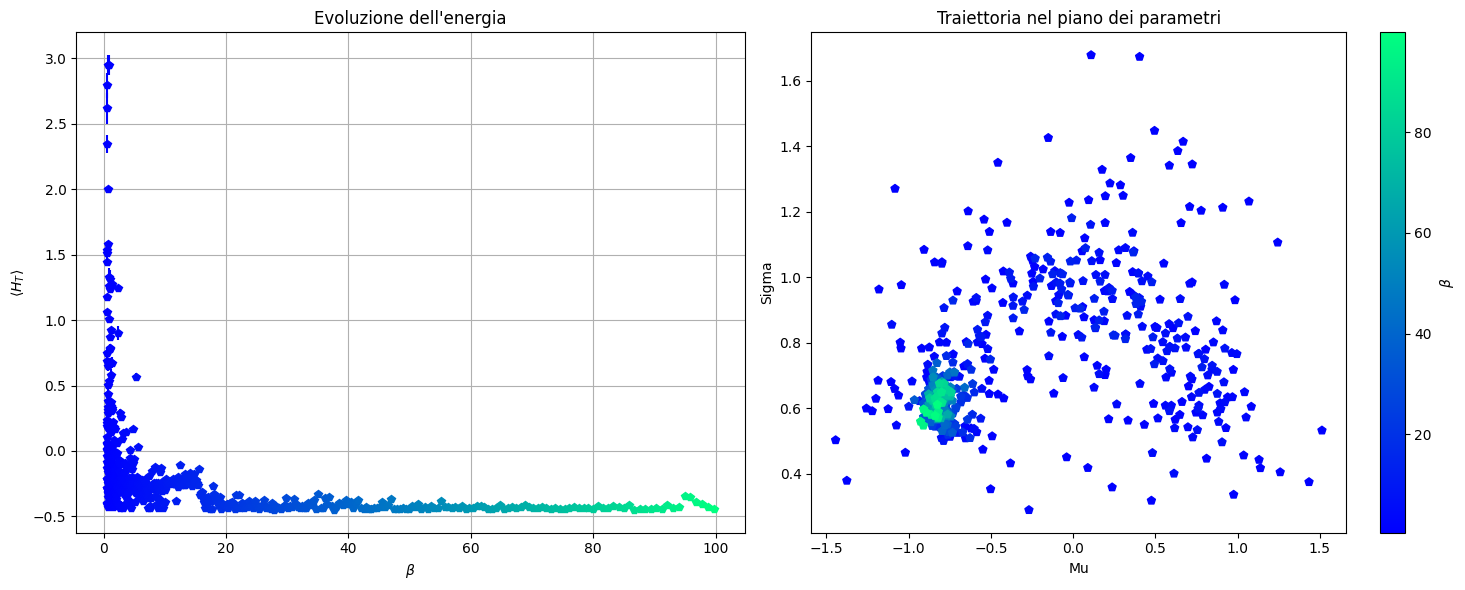

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T, mu, sigma, en, err_en = np.loadtxt("Files_8.2/parameters.dat", unpack=True)
beta = 1/T

# Normalizza beta per il colormap
norm = plt.Normalize(beta.min(), beta.max())
cmap = plt.cm.winter
colors = cmap(norm(beta))

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1, 2, 1)

# Plot 1: Energy vs Beta con colore variabile
for i in range(len(beta)):
    ax1.errorbar(beta[i], en[i], yerr=err_en[i], fmt='p', color=colors[i])

ax1.set_xlabel(r"$\beta$")
ax1.set_ylabel(r"$\langle H_T \rangle$")
ax1.set_title("Evoluzione dell'energia")
ax1.grid(True)

# Plot 2: Mu vs Sigma con colore da Beta
ax2 = fig.add_subplot(1, 2, 2)
sc = ax2.scatter(mu, sigma, c=beta, cmap='winter', marker='p', s=30)
ax2.set_xlabel('Mu')
ax2.set_ylabel('Sigma')
ax2.set_title('Traiettoria nel piano dei parametri')
fig.colorbar(sc, ax=ax2, label=r'$\beta$')

plt.tight_layout()
plt.show()


<div style="width: 48%; float: left;">

A sinistra troviamo un grafico che mostra l'andamento dell'energia stimata in funzione dell'inverso della temperatura $\beta$:

- All'inizio, ossia a temperature alte, l'energia ha un valore molto alto, sintomo del fatto che a queste temperature il sistema esplora configurazioni poco favorevoli.

- Aumentando $\beta$, le fluttuazioni diminuiscono, e l’energia converge gradualmente verso un valore minimo stabile, l'algoritmo sta esplorando sempre più finemente le configurazioni migliori.

</div>
<div style="width: 48%; float: right;">

Il secondo grafico rappresenta la traiettoria delle coppie $(\mu,\sigma)$ che sono state accettate dall'algoritmo (non tutta l'esporazione del piano).

Fase iniziale (blu): i parametri variano molto, con una dispersione ampia nel piano, a causa dell'ampiezza con cui vengono proposte le coppie. 

Fase finale (azzurro): i punti si concentrano in una regione più ristretta, a indicare che i parametri stanno convergendo verso quelli ottimali.



</div>
<div style="clear: both;"></div>